In [1072]:
# Assumptions:
    
# Duplicate rows of part no for same week.Assuming observations has been taken for different days in the same week.
# S0 taken sum of values of a Part no for a specific week in a specific month for a specific year

# Many Part_no has throughout values very small like 5,9.So haven't considered them in the model.Anyways there are 190 unique Parts 
# and it hadn't been possible to consider all of them.

# Constraints:
#     Other factors can be considered like
#     weather conditions
#     humidity
#     accident prone factor
#     economy
#     public transport
#     population.
    
#     But without knowledge of the region for which this company will operate these fields couldnt be applied.
    
    
#     Large proportion of values are 0 making it difficult to get good result.Need time to properly cluster Parts and taking the important one.


##Things left to be implemented
# Optimization of hyperparameters
# Using LSTM
# Using all the parts in the model


In [1270]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [1282]:
##Reading the file
auto_parts=pd.read_csv("Documents/New folder/Airlines_test/UseCase2_AutomotivePartsSales - sheet-1 (2).csv")

In [1283]:
auto_parts.shape

(340, 207)

In [1284]:
##Transposing the dataframe
auto=auto_parts.transpose()
cols=auto.columns[3:]
cols

a=auto.loc[:, (0,1,2,col)]
a[0].unique()

array(['Year', '2016', '2017', '2018', '2019'], dtype=object)

In [1285]:
##Arranging the dataset such that there will be columns like 'Year','Month','Week','Value','Part_no'
i=1
for col in cols:
   
    a=auto.loc[:, (0,1,2,col)]
    a['Part_no']=a[col][0]

    a.columns=['Year','Month','Week','Value','Part_no']
    
    a=a.iloc[1:,:]
    
    if(i==1):
        b=a
    elif(i==2):
        all_parts=b.append(a)
    else:
        all_parts=all_parts.append(a)
    i=i+1


In [1286]:
all_parts['Value'].replace({" ": 0}, inplace=True)
all_parts['Year'].unique()

array(['2016', '2017', '2018', '2019'], dtype=object)

In [1287]:
##Changing datatypes to int
import datetime
all_parts.fillna(0)
all_parts.replace(np.nan,0)

all_parts.reset_index(drop=True, inplace=True)
all_parts.isnull().sum()
all_parts['Year']=all_parts['Year'].astype(int)
all_parts['Value']=all_parts['Value'].astype(int)
all_parts['Week'] =all_parts['Week'].astype(int)
# datetime_object = datetime.datetime.strptime(month_name, "%b")
##Changing MOnth to numeric value
d = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5,'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10,'Nov':11, 'Dec':12}
all_parts.Month = all_parts.Month.map(d)

# all_parts['Month'] =all_parts['Month'].astype(int)

In [1288]:
##Taking sum of all duplicate rows for each Part no for a specific week
all_parts=all_parts.groupby(["Year","Month","Week","Part_no"], as_index=False)["Value"].sum()
len(all_parts.Part_no.unique())


190

In [1291]:
all_parts.dtypes

Year        int64
Month       int64
Week        int64
Part_no    object
Value       int32
dtype: object

In [1292]:
##Creating the date field
from datetime import datetime
import pandas as pd

def year_week(y, w):
    return datetime.strptime(f'{y} {w} 1', '%G %V %u')


all_parts['year_week_ts'] = all_parts.apply(lambda row: year_week(row.Year, row.Week), axis=1)
all_parts['year_week_str'] = all_parts.apply(lambda row: row.year_week_ts.strftime('%G-%V'), axis=1)


In [1293]:
##Total Sales of all parts
all_parts_total=all_parts.groupby(["Year","Month","Week"], as_index=False)["Value"].sum()
all_parts_total
all_parts_total['year_week_ts'] = all_parts_total.apply(lambda row: year_week(row.Year, row.Week), axis=1)
all_parts_total['year_week_str'] = all_parts_total.apply(lambda row: row.year_week_ts.strftime('%G-%V'), axis=1)

all_parts_total.index=all_parts_total['year_week_ts']
cl1=all_parts_total.drop(['Year', 'Month', 'Week','year_week_str'], axis=1)
cl1.index=pd.to_datetime(cl1.index)
cl1.index=cl1.index.to_period('W')
cl1=cl1.drop(['year_week_ts'], axis=1)
# cl1.plot(figsize=(15, 6))
# plt.show()


In [1295]:
##Checking stationarity of the dataset and we can see that its -1 which is greater than critical value so not stationaryX=cl1.values
diff = list()
for i in range(1, len(X)):
    value = X[i]
    diff.append(value)
X=Series(diff)
print(type(X))
result = adfuller(X)
result
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

<class 'pandas.core.series.Series'>
ADF Statistic: -1.803663
p-value: 0.378645
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


In [1296]:
##Stationarity check after differencing

def difference(cl1):
	diff = list()
	for i in range(1, len(cl1)):
		value = cl1[i] - cl1[i - 1]
		diff.append(value)
	return Series(diff)
X = cl1.values
# difference data
stationary = difference(X)
stationary.index = cl1.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
# stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -8.229419
p-value: 0.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


year_week_ts
2016-01-04/2016-01-10             NaN
2016-01-11/2016-01-17             NaN
2016-01-18/2016-01-24             NaN
2016-01-25/2016-01-31    54738.428571
2016-02-01/2016-02-07    63697.000000
                             ...     
2019-10-28/2019-11-03    71257.285714
2019-11-04/2019-11-10    74779.857143
2019-11-11/2019-11-17             NaN
2019-11-18/2019-11-24             NaN
2019-11-25/2019-12-01             NaN
Freq: W-SUN, Name: Value, Length: 206, dtype: float64
year_week_ts
2016-01-04/2016-01-10   -1929.343546
2016-01-11/2016-01-17    2838.549311
2016-01-18/2016-01-24   -1443.884362
2016-01-25/2016-01-31   -2147.119760
2016-02-01/2016-02-07    1306.491078
                            ...     
2019-10-28/2019-11-03    1022.959058
2019-11-04/2019-11-10     352.348221
2019-11-11/2019-11-17   -1929.343546
2019-11-18/2019-11-24    2838.549311
2019-11-25/2019-12-01   -1443.884362
Freq: W-SUN, Name: Value, Length: 206, dtype: float64
year_week_ts
2016-01-04/2016-01-10       

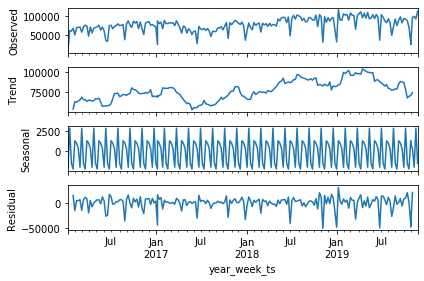

In [1297]:
##Checking trend,seasonality and cyclic behavior

# cl1.index=cl1.index.to_timestamp()
result = seasonal_decompose(cl1["Value"], model='additive',freq = 7)
fig = result.plot()
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

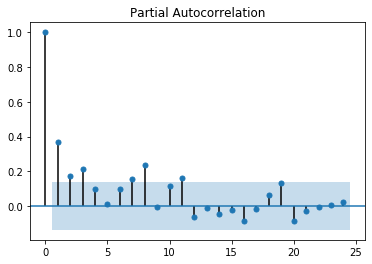

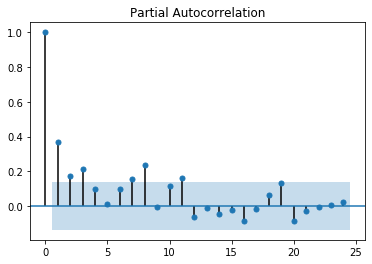

In [1298]:
##Partial autocorrelation plot
plot_pacf(cl1)

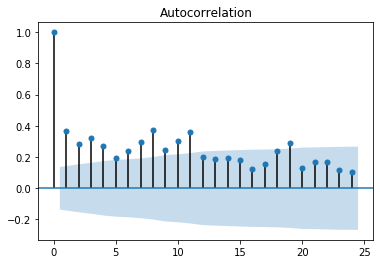

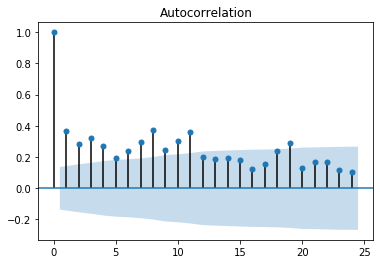

In [1299]:
##Partial Autocorrelation plot
plot_acf(cl1)

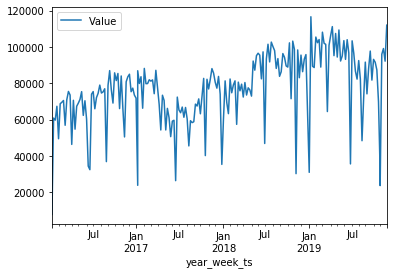

In [1300]:
##Plotting the sales of all parts.There are drops in July month of all years.
cl1.plot()

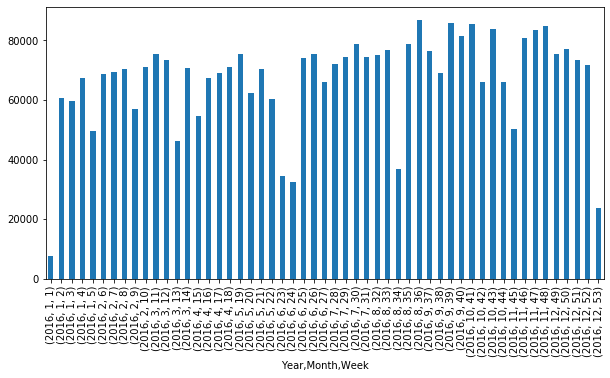

In [1301]:
##Year wise barplot
all_partssyear=all_parts[all_parts.Year.isin ([2016])]
all_parts1 = all_partssyear.groupby([all_partssyear['Year'],all_partssyear['Month'],all_partssyear['Week']]
                          )['Value'].sum()
all_parts1.plot(kind='bar',figsize=(10,5),legend=None)

In [1302]:
##Taking lag values and Differenced values
import numpy as np
all_parts['Lastweek_Sales'] = all_parts.groupby(['Part_no'])['Value'].shift()
all_parts['Last_Week_Diff'] = all_parts.groupby(['Part_no'])['Lastweek_Sales'].diff()
all_parts['Last-10_Week_Sales'] = all_parts.groupby(['Part_no'])['Value'].shift(10)
# all_parts['Last-10_Week_Diff'] = all_parts.groupby(['Part_no'])['Last-10_Week_Sales'].diff()
all_parts['Last-11_Week_Sales'] = all_parts.groupby(['Part_no'])['Value'].shift(11)
# all_parts['Last-11_Week_Diff'] = all_parts.groupby(['Part_no'])['Last-11_Week_Sales'].diff()
all_parts['Last-12_Week_Sales'] = all_parts.groupby(['Part_no'])['Value'].shift(12)
# all_parts['Last-12_Week_Diff'] = all_parts.groupby(['Part_no'])['Last-12_Week_Sales'].diff()
all_parts.fillna(0)
all_parts.replace(np.nan,0)
all_parts.fillna(0, inplace=True)

In [1303]:
##Fetching the quarter value
all_parts['YM']=all_parts.apply(lambda row: (str(row.Year)+'-'+str(row.Month)), axis=1)
all_parts['Qtr'] = pd.to_datetime(all_parts.YM).dt.quarter


In [1304]:
##Sorting the dataframe based on total sales of Part nos throught the tenure
all_parts1=all_parts
all_parts_lowsales=all_parts.groupby(["Part_no"], as_index=False)["Value"].sum()
all_parts_lowsales=all_parts_lowsales.sort_values('Value')


In [1306]:
##Getting the mean sales value
all_parts_lowsales['Value'].mean()

83419.23157894737

In [1307]:
##Getting the max sales value
all_parts_lowsales['Value'].max()

794252

In [1308]:
##Getting the min sales value
all_parts_lowsales['Value'].min()

5

<BarContainer object of 190 artists>

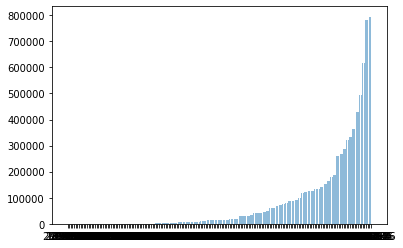

In [1309]:
##Plotting a bar chart and we can see maximum Parts have sales less than 100000

plt.bar(all_parts_lowsales['Part_no'], all_parts_lowsales['Value'], align='center', alpha=0.5)

In [1311]:
##Identifying important parts
all_parts_highest=all_parts_lowsales[all_parts_lowsales['Value']>400000]
highest_partssales=all_parts_highest.Part_no
highest_partssales

41       29032640
40       29032639
32     29032587DL
33     29032588DL
58       29032794
57       29032793
124      29033234
126      29033235
38       29032635
39       29032636
Name: Part_no, dtype: object

In [1312]:
##Identifying the Parts for which sales is 0 throughout 2019 we shouldnt consider them as model will be not good then.
all_parts_2019=all_parts[all_parts.Year==2019]
all_parts_totsales=all_parts_2019.groupby(["Part_no"], as_index=False)["Value"].sum()
all_parts_2019_with_0_sales=all_parts_totsales[all_parts_totsales.Value==0].Part_no.unique()
all_parts_2019_with_0_sales

##Identifying the Parts for which sales is 0 throughout 2018 we shouldnt consider them as model will be not good then.

all_parts_2018=all_parts[all_parts.Year==2018]
all_parts_totsales_2018=all_parts_2018.groupby(["Part_no"], as_index=False)["Value"].sum()
all_parts_2018_with_0_sales=all_parts_totsales_2018[all_parts_totsales_2018.Value==0].Part_no.unique()
all_parts_2018_with_0_sales

##Identifying the Parts for which sales is 0 throughout 2017 we shouldnt consider them as model will be not good then.

all_parts_2017=all_parts[all_parts.Year==2017]
all_parts_totsales_2017=all_parts_2017.groupby(["Part_no"], as_index=False)["Value"].sum()
all_parts_2017_with_0_sales=all_parts_totsales_2017[all_parts_totsales_2017.Value==0].Part_no.unique()
all_parts_2017_with_0_sales

##Identifying the Parts for which sales is 0 throughout 2016 we shouldnt consider them as model will be not good then.
all_parts_2016=all_parts[all_parts.Year==2016]
all_parts_totsales_2016=all_parts_2016.groupby(["Part_no"], as_index=False)["Value"].sum()
all_parts_2016_with_0_sales=all_parts_totsales_2016[all_parts_totsales_2016.Value==0].Part_no.unique()
all_parts_2016_with_0_sales

# all_parts_lowsales=all_parts_lowsales.sort_values('Value')
# ##Identifying important parts
# all_parts_highest=all_parts_lowsales[all_parts_lowsales['Value']>100000]
# highest_partssales=all_parts_highest.Part_no
# highest_partssales

array(['18345617', '18345618', '29032485', '29032486', '29032487',
       '29032488', '29032627', '29032628', '29032920', '29032921',
       '29033007', '29033008', '29033027DR', '29033028DR', '29033029BC',
       '29033030BC', '29033079', '29033080', '29033093', '29033094',
       '29033095', '29033096', '29033101', '29033102', '29033110',
       '29033111', '29033127', '29033128', '29033129', '29033130',
       '29033143', '29033148', '29033149', '29033203', '29033204',
       '29033214', '29033215', '29033216', '29033217', '29033228',
       '29033229', '29033234', '29033234PB', '29033235', '29033235PB',
       '29033236', '29033237', '29033238', '29033239', '29033244',
       '29033245', '29033246', '29033247', '29033252', '29033253',
       '29033254', '29033255', '29033256', '29033257', '29033258',
       '29033259', '29033265', '29033266', '29033267', '29033268',
       '29033274', '29033275', '29033277', '29033278', '29033295',
       '29033296', '29033319', '29033320', '290333

In [1316]:
all_parts_2019_with_0_sales.shape

(9,)

In [1318]:
##Finding Parts with highest sales whose individual 2019 ,2018,2017,2016 sales is not 0
all_parts_highest_without0=all_parts_lowsales[ ~ all_parts_lowsales.Part_no.isin (all_parts_2019_with_0_sales)]
all_parts_highest_without0=all_parts_highest_without0[ ~ all_parts_highest_without0.Part_no.isin (all_parts_2018_with_0_sales)]
all_parts_highest_without0=all_parts_highest_without0[ ~ all_parts_highest_without0.Part_no.isin (all_parts_2017_with_0_sales)]
all_parts_highest_without0=all_parts_highest_without0[ ~ all_parts_highest_without0.Part_no.isin (all_parts_2016_with_0_sales)]
all_parts_highest_without0.Part_no.shape
# 

(96,)

In [1325]:
##Getting 12 highest sales Parts from this cluster where no Parts has zero sales in either 2016,2017,2018,2019
all_parts_highest=all_parts_highest_without0[all_parts_highest_without0['Value']>300000]
highest_partssales=all_parts_highest.Part_no
highest_partssales.shape

(12,)

<BarContainer object of 96 artists>

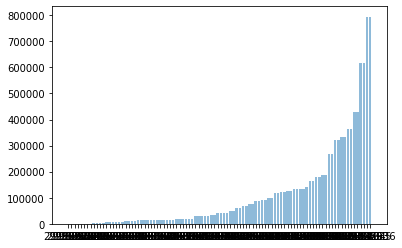

In [1321]:

plt.bar(all_parts_highest_without0['Part_no'], all_parts_highest_without0['Value'], align='center', alpha=0.5)

In [1354]:
##Resetting the index
all_parts.reset_index(drop=True, inplace=True)
all_parts.columns

Index(['Year', 'Month', 'Week', 'Part_no', 'Value', 'year_week_ts',
       'year_week_str', 'Lastweek_Sales', 'Last_Week_Diff',
       'Last-10_Week_Sales', 'Last-11_Week_Sales', 'Last-12_Week_Sales', 'YM',
       'Qtr'],
      dtype='object')

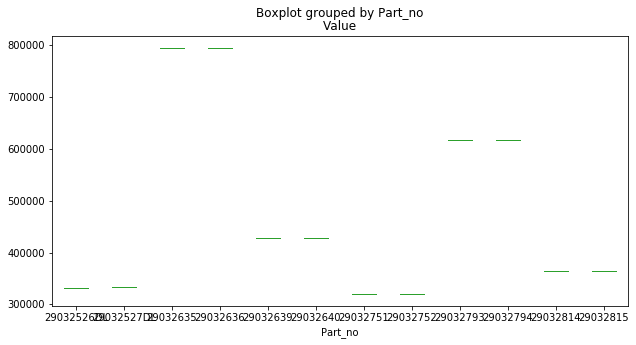

In [1352]:
##Boxplot for 10 highest sales Parts
all_parts_highest.boxplot(by ='Part_no', column =['Value'], grid = False,figsize=(10,5),showfliers=True) 

In [1355]:
##Random Forest Regressor for 12 highest sales Part nos
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))
mean_error_parts=[]
all_parts=all_parts[all_parts.Part_no.isin (highest_partssales)]
for part_no in all_parts['Part_no'].unique():
    mean_error = []
    specificpart_set=all_parts[all_parts.Part_no==part_no]
    for week in range(40,52):
        train = specificpart_set[all_parts.Year.isin ([2017,2016]) | (specificpart_set.Year==2018) & (specificpart_set.Week  < week)]
        val = specificpart_set[(specificpart_set.Year==2018) & (specificpart_set.Week  ==week)]

        xtr, xts = train.drop(['Value','Part_no','Last_Week_Diff','year_week_ts','year_week_str','YM'], axis=1), val.drop(['Value','Last_Week_Diff','Part_no','year_week_ts','year_week_str','YM'], axis=1)
        ytr, yts = train['Last_Week_Diff'].values, val['Last_Week_Diff'].values

        mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)
#         act_pred['Part_no']=part_no
#         act_pred['pred']=p
#         act_pred['act']=yts
        error = rmse(yts, p)
        print('Week %d - Error %.5f' % (week, error))
        mean_error.append(error)
    mean_error_parts.append(np.mean(mean_error))
    print('Mean Error = %.5f' % np.mean(mean_error))

C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 40 - Error 293.35500


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 41 - Error 187.24500


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 42 - Error 269.10000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 43 - Error 102.09900


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 44 - Error 678.29500


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 45 - Error 605.71200


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 46 - Error 529.74000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 47 - Error 1187.62800


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 48 - Error 695.47000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 49 - Error 54.89000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 50 - Error 1050.99200


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 51 - Error 650.11000
Mean Error = 525.38633


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 40 - Error 298.98800


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 41 - Error 190.39600


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 42 - Error 255.63300


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 43 - Error 104.33200


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 44 - Error 672.80200


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 45 - Error 595.71400


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 46 - Error 522.27600


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 47 - Error 1159.67500


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 48 - Error 716.67500


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 49 - Error 61.56700


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 50 - Error 1092.17400


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 51 - Error 655.47500
Mean Error = 527.14225


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 40 - Error 370.33300


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 41 - Error 235.07000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 42 - Error 357.15600


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 43 - Error 239.87900


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 44 - Error 765.04200


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 45 - Error 224.96100


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 46 - Error 483.11500


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 47 - Error 1007.02400


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 48 - Error 691.01800


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 49 - Error 307.25000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 50 - Error 489.70200


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 51 - Error 58.74600
Mean Error = 435.77467


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 40 - Error 369.37700


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 41 - Error 221.47100


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 42 - Error 355.60900


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 43 - Error 230.67500


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 44 - Error 763.39800


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 45 - Error 227.70000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 46 - Error 498.99200


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 47 - Error 1031.72300


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 48 - Error 676.62700


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 49 - Error 312.86000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 50 - Error 481.45900


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 51 - Error 89.64500
Mean Error = 438.29467


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Week 40 - Error 870.26000


C:\Users\aritrikundu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


KeyboardInterrupt: 

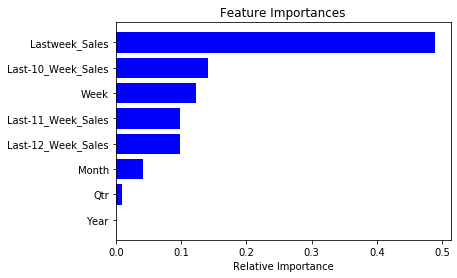

In [1157]:
##Feature importance plot
features = xtr.columns
importances = mdl.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

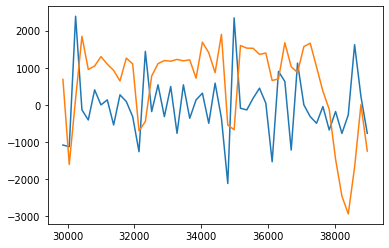

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


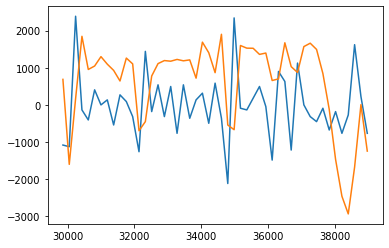

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


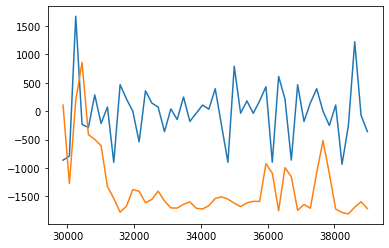

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


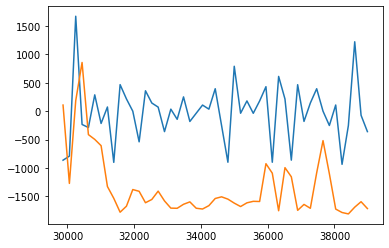

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


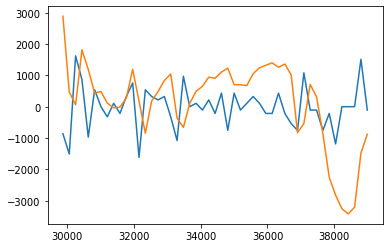

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


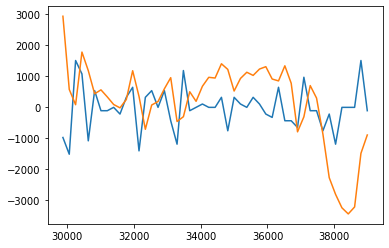

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


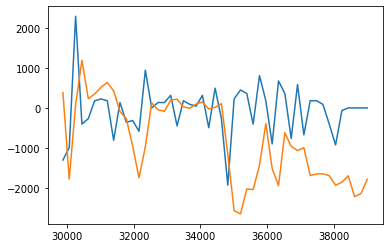

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


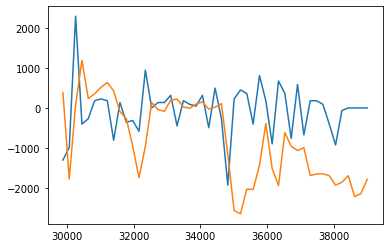

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


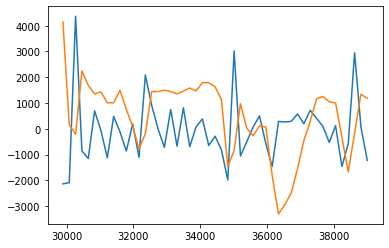

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


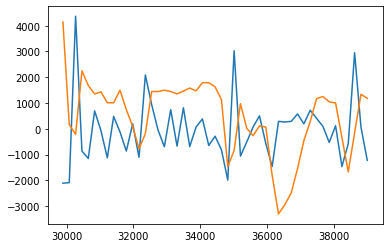

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


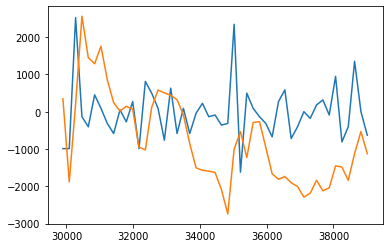

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


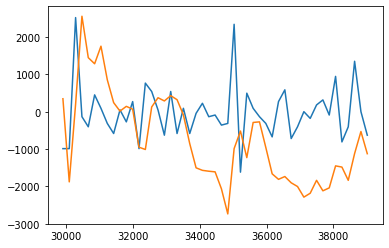

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [1329]:
df2=testset_pred = pd.DataFrame(columns=['Part_no', 'Year', 'Month','Week','Value','Pred'])
test = all_parts[(all_parts.Year==2019) & all_parts.Part_no.isin (highest_partssales)]


i=0
for part_no in test['Part_no'].unique():
    train= all_parts[(all_parts.Year==2018) & (all_parts.Part_no==part_no) & (all_parts.Month==12)]
    train=train.Value.values
        
    specificpart_set=test[test.Part_no==part_no]
    xtest = specificpart_set.drop(['Value','Part_no','year_week_ts','year_week_str','Last_Week_Diff','YM'], axis=1)
    ytest = specificpart_set['Last_Week_Diff'].values
    pred = mdl.predict(xtest)
    
    df2 = pd.DataFrame({"Year":xtest.Year,"Month":xtest.Month,"Week":xtest.Week,"Value":ytest,"Pred":pred}) 
    
    df2['Part_no']=part_no
    
    df2['lag_value']=df2['Pred'].shift()
    df2.iloc[0,6]=train[-1]
    df2.iloc[0,6]=train[-1]
    df2['Undifferenced_value']=df2['Pred']+df2['lag_value']
    pyplot.plot(df2.Value)
    pyplot.plot(df2.Undifferenced_value)
    pyplot.show()
    
    testset_pred=testset_pred.append(df2)
    i=i+1
#     testset_pred['Part_no'][i]=xtest.Part_no[0]


In [1330]:
##RMSE of 2019 data set
rmse = sqrt(mean_squared_error(testset_pred.Value, testset_pred.Undifferenced_value))
rmse

1614.7318725211453

In [1331]:
##Preparing the forecast dataset of next 12 weeks
timeseries=pd.date_range(start='25/11/2019', periods=12,freq='W')
forecast_df = pd.DataFrame(columns=xtest.columns)



forecast_df['year_week_ts']=timeseries
forecast_df['Year']=forecast_df.year_week_ts.dt.year
forecast_df['Month']=pd.DatetimeIndex(forecast_df['year_week_ts']).month
forecast_df['Week']=pd.DatetimeIndex(forecast_df['year_week_ts']).week
forecast_df['YM']=forecast_df.apply(lambda row: (str(row.Year)+'-'+str(row.Month)), axis=1)
forecast_df['Qtr'] = pd.to_datetime(forecast_df.YM).dt.quarter



In [1332]:
##Merging the forecast dataset with 2019 dataset to get lagged variables.
for part_no in test['Part_no'].unique():
    test1=test[test.Part_no==part_no]
    forecast_df['Part_no']=part_no
    
    temp=test1.append(forecast_df)
    temp['Lastweek_Sales'] = temp['Value'].shift()
    temp['Last_Week_Diff'] = temp['Lastweek_Sales'].diff()
    temp['Last-10_Week_Sales'] = temp['Value'].shift(10)
#     temp['Last-10_Week_Diff'] = temp['Last-10_Week_Sales'].diff()
    temp['Last-11_Week_Sales'] = temp['Value'].shift(11)
#     temp['Last-11_Week_Diff'] = temp['Last-11_Week_Sales'].diff()
    temp['Last-12_Week_Sales'] = temp['Value'].shift(12)
#     temp['Last-12_Week_Diff'] = temp['Last-12_Week_Sales'].diff()
    print(temp.iloc[-12:,:])
    mergeddata=mergeddata.append(temp.iloc[-12:,:])
    
       

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


    Last-10_Week_Sales  Last-11_Week_Sales  Last-12_Week_Sales  \
0               2250.0              2745.0              3060.0   
1               2205.0              2250.0              2745.0   
2               1530.0              2205.0              2250.0   
3               1352.0              1530.0              2205.0   
4                585.0              1352.0              1530.0   
5                315.0               585.0              1352.0   
6               1935.0               315.0               585.0   
7               2160.0              1935.0               315.0   
8               1395.0              2160.0              1935.0   
9               2205.0              1395.0              2160.0   
10                 NaN              2205.0              1395.0   
11                 NaN                 NaN              2205.0   

    Last_Week_Diff  Lastweek_Sales  Month     Part_no  Qtr  Value  Week  \
0            810.0          2205.0     12  29032526DL    4    NaN 

11   2020-2  2020           NaN   2020-02-16  
    Last-10_Week_Sales  Last-11_Week_Sales  Last-12_Week_Sales  \
0               2832.0              2424.0              1704.0   
1               2928.0              2832.0              2424.0   
2               2400.0              2928.0              2832.0   
3               2520.0              2400.0              2928.0   
4               1056.0              2520.0              2400.0   
5                480.0              1056.0              2520.0   
6               3432.0               480.0              1056.0   
7               3505.0              3432.0               480.0   
8               2280.0              3505.0              3432.0   
9               3744.0              2280.0              3505.0   
10                 NaN              3744.0              2280.0   
11                 NaN                 NaN              3744.0   

    Last_Week_Diff  Lastweek_Sales  Month   Part_no  Qtr  Value  Week  \
0           1464.0   

In [1333]:
##Forecasting for 12 weeks for each Part
testset_forecast = pd.DataFrame()
for part_no in mergeddata['Part_no'].unique():
    df2=df3 = pd.DataFrame()
    i=0
    part_set=mergeddata[mergeddata.Part_no==part_no]
    while i<12:

        
        
        xforecast = part_set.drop(['Value','Part_no','year_week_ts','year_week_str','Last_Week_Diff','YM'], axis=1)
#         print(xforecast.iloc[i].values.reshape(1, -1))
        forecast = mdl.predict(xforecast.iloc[i].values.reshape(1, -1))
        
        df3 = pd.DataFrame({"Year":xforecast.iloc[i,7],"Month":xforecast.iloc[i,4],"Week":xforecast.iloc[i,6],"Pred":forecast}) 
    
        df3['Part_no']=part_no

        
        
        df3['Undifferenced_value']=forecast+part_set.iloc[i,4]
        df2=df2.append(df3)
        if(i<11):
            part_set.iloc[i+1,4]=forecast+part_set.iloc[i,4]
        
        if(i==0):
            part_set.iloc[11,1]=forecast+part_set.iloc[i,4]
            part_set.iloc[10,0]=forecast+part_set.iloc[i,4]
#             part_set.iloc[11,2]=forecast+part_set.iloc[i,7]
            
        if(i==1):
            part_set.iloc[11,0]=forecast+part_set.iloc[i,4]
#             part_set.iloc[11,2]=forecast+part_set.iloc[i,7]
       
#         if(i==2):
#             part_set.iloc[11,1]=forecast+part_set.iloc[i,7]
#             part_set.iloc[10,1]=forecast+part_set.iloc[i,7]
        print(i)   
        i=i+1
    testset_forecast=testset_forecast.append(df2)
    

C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


3


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


5


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


7


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


8


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


9


C:\Users\aritrikundu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


10
11


In [975]:
##Forecasted values for 10 topmost Parts with highest sales for 12 weeks .
testset_forecast

,Year,Month,Week,Pred,Part_no,Undifferenced_value
0,2019,12,48,0.0,29032587DL,0.0
0,2019,12,49,0.0,29032587DL,0.0
0,2019,12,50,0.0,29032587DL,0.0
0,2019,12,51,0.0,29032587DL,0.0
0,2019,12,52,0.0,29032587DL,0.0
...,...,...,...,...,...,...
0,2020,1,3,1790.9,29033235,27827.2
0,2020,1,4,1790.9,29033235,29618.1
0,2020,2,5,1790.9,29033235,31409.0
0,2020,2,6,1790.9,29033235,33199.9


In [666]:
##LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [667]:
model_lstm = Sequential()
model_lstm.add(LSTM(15, input_shape=(1,8)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_resaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))

In [ ]:
history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_resaped, y_val),epochs=70, batch_size=12, verbose=2, shuffle=False)
y_pre = model_lstm.predict(x_val_resaped)

In [1334]:
##Creating date series index
all_parts.index=all_parts['year_week_ts']
# cl1=all_parts_total.drop(['Year', 'Month', 'Week','year_week_str','year_week_ts'], axis=1)
all_parts.index=pd.to_datetime(all_parts.index)
all_parts.index=all_parts.index.to_period('W')

29032526DL


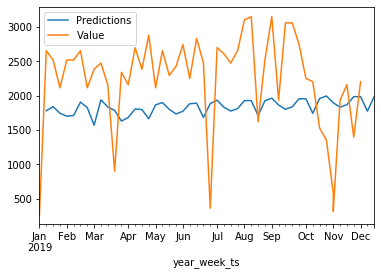

29032527DL


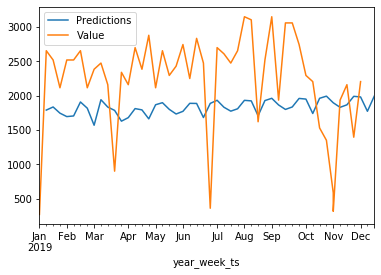

29032635


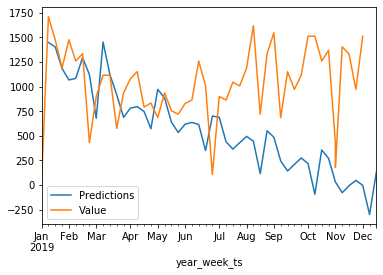

29032636


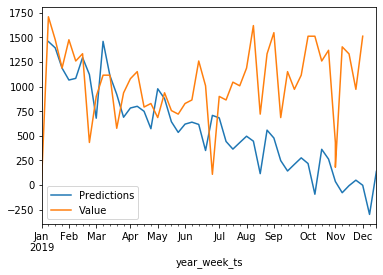

29032639


C:\Users\aritrikundu\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


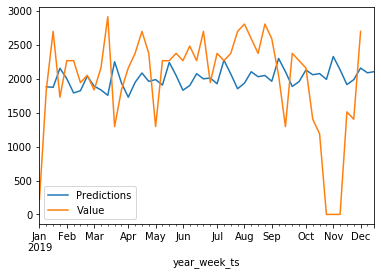

29032640


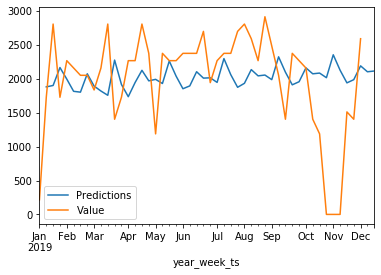

29032751


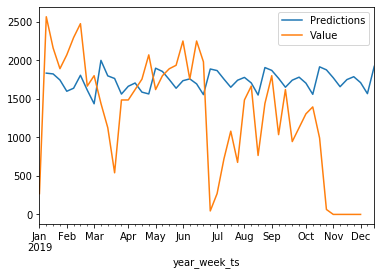

29032752


C:\Users\aritrikundu\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


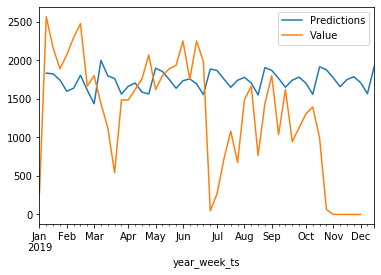

29032793


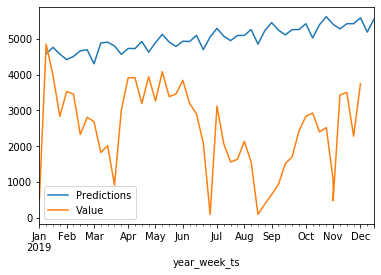

29032794


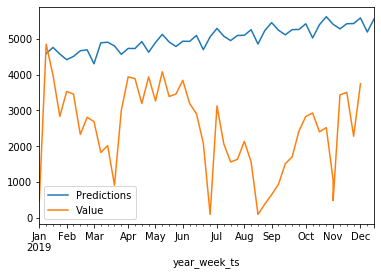

29032814


C:\Users\aritrikundu\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


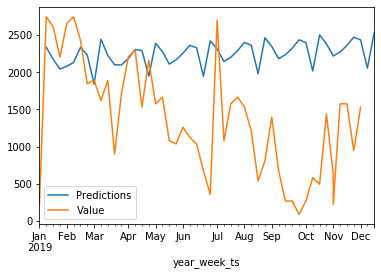

29032815


C:\Users\aritrikundu\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


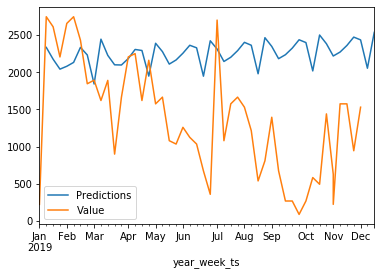

In [1335]:
##Using SARIMA model
df2_arima=testset_pred_arima=pd.DataFrame()
for part_no in all_parts['Part_no'].unique():
    train = all_parts[all_parts.Year.isin([2016,2017,2018]) & (all_parts.Part_no==part_no)] 
    train=train.drop(['Year', 'Month', 'Week', 'Part_no',  'year_week_ts',
           'year_week_str', 'Lastweek_Sales', 'Last_Week_Diff',
           'Last-10_Week_Sales', 'Last-11_Week_Sales', 'Last-12_Week_Sales', 'YM',
           'Qtr'], axis=1)

    test = all_parts[(all_parts.Year.isin([2019])) & (all_parts.Part_no==part_no)] # set one year(12 months) for testing 
    test=test.drop(['Year', 'Month', 'Week', 'Part_no',  'year_week_ts',
           'year_week_str', 'Lastweek_Sales', 'Last_Week_Diff',
           'Last-10_Week_Sales', 'Last-11_Week_Sales', 'Last-12_Week_Sales', 'YM',
           'Qtr'], axis=1)
    print(part_no)
    # Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
    from statsmodels.tsa.statespace.sarimax import SARIMAX 

    model = SARIMAX(train['Value'],  
                    order = (0, 1, 1),  
                    seasonal_order =(2, 1, 1, 8)) 
#     model=auto_arima(train['Value'], start_p = 1, start_q = 1, 
#                           max_p = 3, max_q = 3, m = 12, 
#                           start_P = 0, seasonal = True, 
#                           d = None, D = 1, trace = True, 
#                           error_action ='ignore',   # we don't want to know if an order does not work 
#                           suppress_warnings = True,  # we don't want convergence warnings 
#                           stepwise = True)
    result = model.fit() 
    # result.summary() 
    start = len(train) 
    end = len(train) + len(test) - 1

    # Predictions for one-year against the test set 
    predictions = result.predict(start, end, 
                                 typ = 'levels').rename("Predictions") 

    # plot predictions and actual values 
    predictions.plot(legend = True) 
    test['Value'].plot(legend = True) 
    pyplot.show()
    df2 = pd.DataFrame({"Value":test['Value'].values,"Pred":predictions}) 
    
    df2['Part_no']=part_no
    
    
    
    
    testset_pred_arima=testset_pred_arima.append(df2)

In [1336]:
##RMSE of 2019 data set
rmse = sqrt(mean_squared_error(testset_pred_arima.Value, testset_pred_arima.Pred))
rmse

1430.926791025096

In [1337]:
##Forecasting for 12 weeks.
start = len(train) + len(test) - 1
end = len(train) + len(test) - 1 + 12 -1

    # Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                                 typ = 'levels').rename("Predictions") 


In [1338]:
predictions

2019-12-09/2019-12-15    2535.009165
2019-12-16/2019-12-22    2418.447826
2019-12-23/2019-12-29    2253.402689
2019-12-30/2020-01-05    2306.890743
2020-01-06/2020-01-12    2395.300445
2020-01-13/2020-01-19    2507.478932
2020-01-20/2020-01-26    2469.960191
2020-01-27/2020-02-02    2089.119110
2020-02-03/2020-02-09    2570.949116
2020-02-10/2020-02-16    2454.374803
2020-02-17/2020-02-23    2289.338108
2020-02-24/2020-03-01    2342.820851
Freq: W-SUN, Name: Predictions, dtype: float64

In [1357]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
##Random FOrest has given a good match between predicted values and actual values as we can see from the plot.Need to do further experimentation and optimization
##for better results.Need to use time series modelling like auto.ARIMA with different values of p,d,q